In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from dotenv import load_dotenv
import requests
from pydantic import BaseModel, Field

load_dotenv(override=True)

True

In [ ]:
model=ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [5]:
class llmState(TypedDict):
    question :str
    answer:str
    product :str

In [6]:

class product_structural(BaseModel):
    product:str = Field(..., description="product to search for make is singular exampled 'pant' not 'pants' ")

In [7]:
class question_conditional(BaseModel):
    result: Literal["product", "company"]


In [15]:
def comapany_detail(state:llmState):
    question=state['question']  
    prompt = f""" your name is Sara 
    You are sale analyst working in the company name Highlet

    #intial_conversation :
    welcome then and greet them for contact us


    # Company details 
    company_name : highlet
    company_location : America
    company_number:0987654321
    comapny_email : contact@highlet.com

    # answer the user question
    answer specific to the user question
    {question}
    """
    results=model.invoke(prompt).content
    state['answer']=results

    return {"answer":state['answer']}

In [16]:
def product_node(state:llmState):
    question=state['question']
    prompt= f"find the product name in singular from the user question: {question}"
    llm=model.with_structured_output(product_structural)
    result = llm.invoke(prompt)
    state['product'] = result.product
    product=state['product']
    response = requests.get(("http://127.0.0.1:8000/api/products/?search="
    "{}").format(product))
    if response.status_code == 200:
        products = response.json()
        return {"product":products}
    else:
        return {"error":"Error fetching products"}


In [17]:
def product_answer_node(state:llmState):
    products=state['product']
    prompt=f""" given the product list : {products}
    answer the user question : {state['question']}

    # provide a concise answer based on the product list with price and availability
    """
    answer=model.invoke(prompt).content
    state['answer']=answer

    return {"answer":state['answer']}

In [18]:
def question_conditional_edge(state:llmState) -> Literal["product_node", "company_detail"]:
    question=state['question']
    prompt= f"find the user question is about product or about general company detail: {question}"
    llm=model.with_structured_output(question_conditional)
    result = llm.invoke(prompt)
    if "product" in result.result:
        return "product_node"
    elif "company" in result.result:
        return "company_detail"
    else:
        return "company_detail"

In [19]:
graph=StateGraph(llmState)

graph.add_node("company_detail",comapany_detail)
graph.add_node("product_node",product_node)
graph.add_node("product_answer_node",product_answer_node)

graph.add_conditional_edges(START,question_conditional_edge)
graph.add_edge("product_node","product_answer_node")
graph.add_edge("product_answer_node",END)
graph.add_edge("company_detail",END)

workflow = graph.compile()

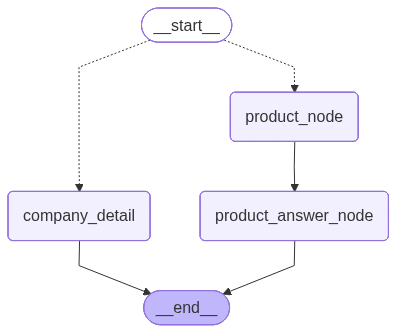

In [20]:
workflow

In [22]:
answer=workflow.invoke({"question" :"what is your name"})["answer"]
answer

'Welcome! Thank you for contacting Highlet. My name is Sara.'